---------------

# **<font style="color:Black">Create OCR by PyTorch</font>**
-------------------
-----------------

In [1]:
!pip install python-Levenshtein
!pip install optuna
!pip install optuna-dashboard --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 59.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 77.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.1 MB/s eta 0:00:00


In [2]:
#!pip install tensorboard
!tensorboard --version

2025-04-03 00:55:29.830434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-03 00:55:30.123615: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-03 00:55:30.207373: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2.17.1


In [3]:
import os
import sys
import shutil
import random
import re
import string
import getpass
import threading
from PIL import Image, ImageDraw, ImageFont, ImageEnhance, ImageFilter
import numpy as np
import cv2

from typing import Iterator, Tuple

import matplotlib.pyplot as plt
from collections import Counter

from Levenshtein import distance as levenshtein_distance

import random

import torch
import torch.nn as nn
import torch.nn.functional as F  # Add this import
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import torch.nn.utils as nn_utils

import optuna
from optuna.trial import Trial
from optuna import visualization 

## **<font style="color:blue">Logger settings</font>**
-------------------

In [4]:
import logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
file_handler = logging.FileHandler("train.log", mode="a", encoding="utf-8")

formatter = logging.Formatter(
    "{asctime} - {levelname} - {message}",
    style="{",
    datefmt="%Y-%m-%d %H:%M",
)

file_handler.setFormatter(formatter)

logger.addHandler(file_handler)


In [5]:
logger.info('Star process of notebook.')

## **<font style="color:blue">Hyperparameters</font>**
-------------------

In [6]:
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [7]:
OUTPUT_DIR = os.path.join('/kaggle','working','synthetic_data','images')
TENSORBOARD_DIR = os.path.join('/kaggle','working','runs')
OPTUNA_DIR = os.path.join('/kaggle','working','optuna')
MODEL_DIR = os.path.join('/kaggle','working','model_dir')
LABELS_FILE = os.path.join('/kaggle','working','synthetic_data','labels.txt')
NUM_SAMPLES = 20480  # Number of images generated
IMG_WIDTH = 128
IMG_HEIGHT = 32
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1.67196984476829e-08
WEIGHT_DECAY =  0.0942890342924316
WARMUP_STEPS = 514
TEMPERATURE = 1.2389791109815292e-06
CTC_ENTROPY_WEIGHT = 0.4723418968547364
CTC_LABEL_SMOOTHING = 0.16862297966320244
CTC_BLANK_PENALTY_WEIGHT = 0.13337416135751246
BSD_BEAM_WIDTH = 12
BSD_BLANK_PENALTY =  -0.10149835756207472
BSD_LENGTH_PENALTY = -0.19953431904018504
GRADIENT_CLIPPING_VALUE = 0.21583555718276623
MAX_SEQ_LENGTH = None
CHARSET = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789- "  # Characters used in license plates
FONT_DIR = os.path.join('/kaggle','input','google-fonts','GoogleFontScripts') # Folder with TrueType fonts (.ttf)
BACKGROUND_DIR = os.path.join('/kaggle','working','backgrounds')  # New folder for background (optional)
NUMBER_BACKGROUND_IMAGE = 4000
NUMBER_OF_OPTUNA_TRIALS = 15
GRADIENT_NORM_TRESHOLD = 100 

In [8]:
logger.info('Set Base hyperparameters.')

## **<font style="color:blue">Utils support functions</font>**
-------------------

### **<font style="color:green">Create output folders</font>**

In [9]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(BACKGROUND_DIR, exist_ok=True)
os.makedirs(TENSORBOARD_DIR, exist_ok=True)
os.makedirs(OPTUNA_DIR, exist_ok=True)

# Creates a new file
with open(LABELS_FILE, 'w') as fp:
    pass

In [10]:
logger.info('Create dirs structure.')

### **<font style="color:green">Load the font list (add the paths to the .ttf files to the "fonts" folder)</font>**

In [11]:
font_files = [
    os.path.join(FONT_DIR, f) for f in os.listdir(FONT_DIR) 
    if f.endswith('.ttf') and os.path.isfile(os.path.join(FONT_DIR, f))
]
if not font_files:
    raise FileNotFoundError("No fonts found in 'fonts' folder. Add .ttf files!")
    logger.error("No fonts found in 'fonts' folder. Add .ttf files!")

In [12]:
logger.info('Load google-fonts files from dataset.')

### **<font style="color:green">Generating a simple gradient background</font>**

In [13]:
def generate_gradient_background(filename, size=(128, 32)):
    """
    Generates a gradient background image and saves it to a specified file.

    This function creates a grayscale image with a soft gradient effect, where the color transitions
    from a lighter gray at the top to a slightly darker gray at the bottom. The image is then blurred
    to create a smooth background effect.

    Args:
        filename (str): The name of the file where the generated image will be saved.
        size (tuple, optional): The dimensions (width, height) of the generated image. Defaults to (128, 32).

    The function uses the Python Imaging Library (PIL) to create and manipulate the image.
    """
    img = Image.new('L', size, color=230)  # Lighter gray as a base
    draw = ImageDraw.Draw(img)
    for y in range(size[1]):
        # Soft gradient with low contrast
        color = int(230 - 20 * (y / size[1]))  # From light gray to slightly darker
        draw.line([(0, y), (size[0], y)], fill=color)
    # Background blur
    img = img.filter(ImageFilter.GaussianBlur(radius=2))
    img.save(os.path.join(BACKGROUND_DIR, filename))

### **<font style="color:green">Generate a background with noise (paper texture)</font>**

In [14]:
def generate_paper_texture(filename, size=(128, 32)):
    img = Image.new('L', size, color=220)  # Lighter gray
    noise = np.random.normal(0, 5, size).astype(np.uint8)  # Less noise
    noise_img = Image.fromarray(noise)
    img.paste(noise_img, (0, 0), noise_img)
    # Blur for a softer effect
    img = img.filter(ImageFilter.GaussianBlur(radius=1.5))
    img.save(os.path.join(BACKGROUND_DIR, filename))

### **<font style="color:green">Creating multiple backgrounds</font>**

In [15]:
for i in range(NUMBER_BACKGROUND_IMAGE):
    generate_gradient_background(f"gradient_{i}.png")
    generate_paper_texture(f"paper_{i}.png")

In [16]:
logger.info('Background images was generated.')

### **<font style="color:green">Load backgrounds (optional, add images to the "backgrounds" folder)</font>**

In [17]:
background_files = (
    [os.path.join(BACKGROUND_DIR, f) for f in os.listdir(BACKGROUND_DIR) 
     if f.endswith(('.png', '.jpg', '.jpeg'))] if os.path.exists(BACKGROUND_DIR) else []
)

In [18]:
logger.info('Background images was loaded for useing.')

### **<font style="color:green">List of setting type of formats</font>**

In [19]:
formats = {
    "Czech Republic": [
        {
            "regex": r"[A-Z]\d[A-Z]{5}",
            "description": "One letter, one digit, five letters",
            "weight": 0.95  # Kept the same
        },
        {
            "regex": r"[A-Z]\d-[A-Z]{5}",
            "description": "One letter, one digit, dash, five letters",
            "weight": 0.05  # Kept the same
        }
    ],
    "Germany": [
        {
            "regex": r"[A-Z]-[A-Z]{2} \d{3}",
            "description": "One letter, dash, two letters, space, three digits",
            "weight": 0.15  # Reduced from 0.2 to reduce space and dash frequency
        },
        {
            "regex": r"[A-Z]{4}\d{2}",
            "description": "Four letters, two digits",
            "weight": 0.15  # Increased from 0.1 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.7  # Kept the same
        }
    ],
    "France": [
        {
            "regex": r"[A-Z]{2}-\d{3}-[A-Z]{2}",
            "description": "Two letters, dash, three digits, dash, two letters",
            "weight": 0.15  # Reduced from 0.2 to reduce dash frequency
        },
        {
            "regex": r"[A-Z]{2} \d{3} [A-Z]{2}",
            "description": "Two letters, space, three digits, space, two letters",
            "weight": 0.15  # Reduced from 0.2 to reduce space frequency
        },
        {
            "regex": r"[A-Z]{2}\d{3}[A-Z]{2}",
            "description": "Two letters, three digits, two letters",
            "weight": 0.15  # Increased from 0.1 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{4}\d{2}",
            "description": "Four letters, two digits",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.45  # Kept the same
        }
    ],
    "United Kingdom": [
        {
            "regex": r"[A-Z]{2}\d{2} [A-Z]{3}",
            "description": "Two letters, two digits, space, three letters",
            "weight": 0.15  # Reduced from 0.2 to reduce space frequency
        },
        {
            "regex": r"[A-Z]{2}\d{2}[A-Z]{3}",
            "description": "Two letters, two digits, three letters",
            "weight": 0.15  # Increased from 0.1 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{4}\d{1}",
            "description": "Four letters, one digit",
            "weight": 0.7  # Kept the same
        }
    ],
    "Brazil": [
        {
            "regex": r"\d{3}[A-Z]{4}",
            "description": "Three digits, four letters",
            "weight": 0.35  # Increased from 0.3 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{4}\d{2}",
            "description": "Four letters, two digits",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{3}-\d{2}-[A-Z]{2}",
            "description": "Three letters, dash, two digits, dash, two letters",
            "weight": 0.15  # Reduced from 0.2 to reduce dash frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.4  # Reduced from 0.45 to balance overall distribution
        }
    ],
    "Australia": [
        {
            "regex": r"[A-Z]{3}-\d{3}",
            "description": "Three letters, dash, three digits",
            "weight": 0.15  # Reduced from 0.2 to reduce dash frequency
        },
        {
            "regex": r"[A-Z]{3} \d{3}",
            "description": "Three letters, space, three digits",
            "weight": 0.15  # Reduced from 0.2 to reduce space frequency
        },
        {
            "regex": r"[A-Z]{4}\d{2}",
            "description": "Four letters, two digits",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.6  # Increased from 0.55 to maintain letter frequency
        }
    ],
    "Austria": [
        {
            "regex": r"\d[A-Z]{4}\d{2}",
            "description": "One digit, four letters, two digits",
            "weight": 0.35  # Increased from 0.3 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.5  # Kept the same
        },
        {
            "regex": r"\d-[A-Z]{4}-\d{2}",
            "description": "One digit, dash, four letters, dash, two digits",
            "weight": 0.05  # Reduced from 0.1 to reduce dash frequency
        },
        {
            "regex": r"\d [A-Z]{4} \d{2}",
            "description": "One digit, space, four letters, space, two digits",
            "weight": 0.1  # Kept the same
        }
    ],
    "Italy": [
        {
            "regex": r"[A-Z]{2} \d{3}[A-Z]{2}",
            "description": "Two letters, space, three digits, space, two letters",
            "weight": 0.15  # Reduced from 0.2 to reduce space frequency
        },
        {
            "regex": r"[A-Z]{2}-\d{3}[A-Z]{2}",
            "description": "Two letters, dash, three digits, two letters",
            "weight": 0.15  # Reduced from 0.2 to reduce dash frequency
        },
        {
            "regex": r"[A-Z]{2}\d{3}[A-Z]{2}",
            "description": "Two letters, three digits, two letters",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{4}\d{2}",
            "description": "Four letters, two digits",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.5  # Kept the same
        }
    ],
    "Belgium": [
        {
            "regex": r"\d-[A-Z]{3}-\d{3}",
            "description": "One digit, dash, three letters, dash, three digits",
            "weight": 0.15  # Reduced from 0.2 to reduce dash frequency
        },
        {
            "regex": r"[A-Z]{4}\d{2}",
            "description": "Four letters, two digits",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.55  # Kept the same
        },
        {
            "regex": r"[A-Z] \d{3} [A-Z]{3}",
            "description": "One letter, space, three digits, space, three letters",
            "weight": 0.2  # Kept the same
        }
    ],
    "Spain": [
        {
            "regex": r"[A-Z]{4}\d{3}",
            "description": "Four letters, three digits",
            "weight": 0.35  # Increased from 0.3 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{4}-\d{2}-[A-Z]",
            "description": "Four letters, dash, two digits, dash, one letter",
            "weight": 0.15  # Reduced from 0.2 to reduce dash frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.4  # Kept the same
        },
        {
            "regex": r"[A-Z]{4} \d{2} [A-Z]",
            "description": "Four letters, space, two digits, space, one letter",
            "weight": 0.1  # Kept the same
        }
    ],
    "Hungary": [
        {
            "regex": r"[A-Z] \d{2} [A-Z]{3}",
            "description": "One letter, space, two digits, space, three letters",
            "weight": 0.15  # Reduced from 0.2 to reduce space frequency
        },
        {
            "regex": r"[A-Z]\d{2}[A-Z]{3}",
            "description": "One letter, two digits, three letters",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{4}\d{1}",
            "description": "Four letters, one digit",
            "weight": 0.65  # Kept the same
        },
        {
            "regex": r"[A-Z]\d-[A-Z]{3}-\d",
            "description": "One letter, one digit, dash, three letters, dash, one digit",
            "weight": 0.1  # Kept the same
        }
    ],
    "Norway": [
        {
            "regex": r"\d{2}[A-Z]{5}",
            "description": "Two digits, five letters",
            "weight": 0.35  # Increased from 0.3 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{2}-\d{2}-[A-Z]{3}",
            "description": "Two letters, dash, two digits, dash, three letters",
            "weight": 0.15  # Reduced from 0.2 to reduce dash frequency
        },
        {
            "regex": r"[A-Z]{2} \d{2} [A-Z]{3}",
            "description": "Two letters, space, two digits, space, three letters",
            "weight": 0.15  # Reduced from 0.2 to reduce space frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.35  # Increased from 0.3 to maintain letter frequency
        }
    ],
    "Sweden": [
        {
            "regex": r"[A-Z]{3} \d{3}",
            "description": "Three letters, space, three digits",
            "weight": 0.15  # Reduced from 0.2 to reduce space frequency
        },
        {
            "regex": r"[A-Z]{4}\d{2}",
            "description": "Four letters, two digits",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.75  # Kept the same
        }
    ],
    "Netherlands": [
        {
            "regex": r"[A-Z]{2}-\d{2}-[A-Z]{2}",
            "description": "Two letters, dash, two digits, dash, two letters",
            "weight": 0.15  # Reduced from 0.2 to reduce dash frequency
        },
        {
            "regex": r"[A-Z]{2}\d{2}[A-Z]{2}",
            "description": "Two letters, two digits, two letters",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{4}\d{1}",
            "description": "Four letters, one digit",
            "weight": 0.55  # Kept the same
        },
        {
            "regex": r"[A-Z]{2} \d{2} [A-Z]{2}",
            "description": "Two letters, space, two digits, space, two letters",
            "weight": 0.2  # Reduced from 0.2 to maintain balance
        }
    ],
    "Serbia": [
        {
            "regex": r"[A-Z]{2} \d{3}-[A-Z]{2}",
            "description": "Two letters, space, three digits, dash, two letters",
            "weight": 0.15  # Reduced from 0.2 to reduce space and dash frequency
        },
        {
            "regex": r"[A-Z]{2}\d{3}[A-Z]{2}",
            "description": "Two letters, three digits, two letters",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{4}\d{2}",
            "description": "Four letters, two digits",
            "weight": 0.05  # Kept the same
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.7  # Kept the same
        }
    ],
    "Ukraine": [
        {
            "regex": r"\d{2}[A-Z]{4}\d{2}",
            "description": "Two digits, four letters, two digits",
            "weight": 0.35  # Increased from 0.3 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.5  # Kept the same
        },
        {
            "regex": r"\d{2}-[A-Z]{4}-\d",
            "description": "Two digits, dash, four letters, dash, one digit",
            "weight": 0.05  # Reduced from 0.1 to reduce dash frequency
        },
        {
            "regex": r"\d{2} [A-Z]{4} \d",
            "description": "Two digits, space, four letters, space, one digit",
            "weight": 0.1  # Kept the same
        }
    ],
    "USA_v1": [
        {
            "regex": r"[A-Z]{4}\d{2}",
            "description": "Four letters, two digits",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.9  # Reduced from 0.95 to balance overall distribution
        }
    ],
    "USA_v2": [
        {
            "regex": r"\d{3}-[A-Z]{3}",
            "description": "Three digits, dash, three letters",
            "weight": 0.15  # Reduced from 0.2 to reduce dash frequency
        },
        {
            "regex": r"\d{3} [A-Z]{3}",
            "description": "Three digits, space, three letters",
            "weight": 0.15  # Reduced from 0.2 to reduce space frequency
        },
        {
            "regex": r"[A-Z]{4}\d{2}",
            "description": "Four letters, two digits",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.6  # Increased from 0.55 to maintain letter frequency
        }
    ]
}

### **<font style="color:green">Random text generation function</font>**

In [20]:
def generate_random_license_plate_from_regex(regex_format):
    license_plate = ""
    i = 0
    
    while i < len(regex_format):
        char = regex_format[i]

        # Handle escaped sequences like \d or \w
        if char == '\\' and i + 1 < len(regex_format):
            next_char = regex_format[i + 1]
            repeat = 1
            i += 2  # Skip backslash and the next character

            # Check for repetition pattern {n}
            if i < len(regex_format) and regex_format[i] == '{':
                match = re.match(r"\{(\d+)\}", regex_format[i:])
                if match:
                    repeat = int(match.group(1))
                    i += len(match.group(0))  # Skip {n}

            if next_char == 'd':
                license_plate += ''.join(random.choice(string.digits) for _ in range(repeat))
            elif next_char == 'w':
                license_plate += ''.join(random.choice(string.ascii_uppercase) for _ in range(repeat))
            else:
                license_plate += next_char  # Treat as literal if not \d or \w

        # Handle character classes like [A-Z] or [0-9]
        elif char == '[':
            j = regex_format.find(']', i)
            if j != -1:
                options = regex_format[i+1:j]
                i = j + 1  # Move past ]

                repeat = 1
                if i < len(regex_format) and regex_format[i] == '{':
                    match = re.match(r"\{(\d+)\}", regex_format[i:])
                    if match:
                        repeat = int(match.group(1))
                        i += len(match.group(0))  # Skip {n}

                if options == 'A-Z':
                    license_plate += ''.join(random.choice(string.ascii_uppercase) for _ in range(repeat))
                elif options == '0-9':
                    license_plate += ''.join(random.choice(string.digits) for _ in range(repeat))
                else:
                    license_plate += ''.join(random.choice(options) for _ in range(repeat))
            else:
                license_plate += char  # Unmatched [, treat as literal

        # Handle literal characters (e.g., space, dash)
        else:
            license_plate += char
            i += 1

    return license_plate

In [21]:
def generate_random_license_plate(formats):
    # Choose a random country
    country = random.choice(list(formats.keys()))
    country_formats = formats[country]

    # If the format is a list (multiple options), select by weight
    if isinstance(country_formats, list):
        weights = [fmt["weight"] for fmt in country_formats]
        chosen_format = random.choices(country_formats, weights=weights, k=1)[0]
        regex_format = chosen_format["regex"]
    else:
        regex_format = country_formats["regex"]

    # Generate license plate according to selected regex
    license_plate = generate_random_license_plate_from_regex(regex_format)
    return license_plate, country

In [22]:
# Test code
for _ in range(10):
    license_plate, country = generate_random_license_plate(formats)
    print(f"Country: {country}, License Plate: {license_plate}")
    logger.debug(f'Testing generation of Licence Plate text\n: Country: {country}, License Plate: {license_plate}\n')

Country: Italy, License Plate: ELTPU9
Country: France, License Plate: PIRHG7
Country: USA_v2, License Plate: PMUEH2
Country: USA_v1, License Plate: AVYCF9
Country: Germany, License Plate: AIPTX6
Country: Netherlands, License Plate: ZSOE5
Country: United Kingdom, License Plate: PG46 YUJ
Country: Netherlands, License Plate: MSLR9
Country: Netherlands, License Plate: KVAI9
Country: Australia, License Plate: KRSSD3


### **<font style="color:green">Functions for adding noise and distortions</font>**

In [23]:
def add_noise_and_distortion(img):
    """
    Adds random noise and distortion effects to an input image.

    This function takes an image as input and applies random Gaussian noise, rotation, and perspective distortion to simulate real-world imperfections. 
    The modifications are applied randomly to create variability in the output.

    Args:
        img (PIL.Image.Image): The input image to which noise and distortion will be applied.

    Returns:
        PIL.Image.Image: The modified image with added noise and distortion effects.

    The function uses NumPy for array manipulations and OpenCV for image transformations.
    """
    img_array = np.array(img)

    # Add Gaussian noise
    if random.random() > 0.5:
        noise = np.random.normal(0, random.randint(10, 25), img_array.shape).astype(np.uint8)
        img_array = cv2.add(img_array, noise)

    # Apply rotation
    angle = random.uniform(-5, 5)
    rows, cols = img_array.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    img_array = cv2.warpAffine(img_array, M, (cols, rows))

    # Apply perspective distortion
    src_points = np.float32([[0, 0], [cols-1, 0], [0, rows-1], [cols-1, rows-1]])
    dst_points = np.float32([
        [random.uniform(0, 5), random.uniform(0, 5)],
        [cols-1-random.uniform(0, 5), random.uniform(0, 5)],
        [random.uniform(0, 5), rows-1-random.uniform(0, 5)],
        [cols-1-random.uniform(0, 5), rows-1-random.uniform(0, 5)]
    ])
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    img_array = cv2.warpPerspective(img_array, matrix, (cols, rows))

    return Image.fromarray(img_array)

### **<font style="color:green">Improved image generation feature</font>**

In [24]:
def generate_synthetic_image(text, font_path, img_size=(IMG_WIDTH, IMG_HEIGHT)):
    """
    Generates a synthetic image with specified text and font, optionally using a background image.

    This function creates an image with a given text rendered using a specified font. 
    The image can have a background selected from available background files or a generated gradient background. 
    The text is positioned randomly within the image, and the function ensures that the text fits within the image dimensions by adjusting the font size or shortening the text if necessary. 
    The image is then modified with noise and distortion effects to simulate real-world conditions.

    Args:
        text (str): The text to be rendered on the image.
        font_path (str): The file path to the TrueType font to be used for rendering the text.
        img_size (tuple, optional): The dimensions (width, height) of the generated image. Defaults to (IMG_WIDTH, IMG_HEIGHT).

    Returns:
        PIL.Image.Image: The generated synthetic image with the specified text and effects.

    The function uses the Python Imaging Library (PIL) for image creation and manipulation, and it relies on the `add_noise_and_distortion` function to apply additional effects to the image.
    """
    # Background
    if background_files:
        bg_path = random.choice(background_files)
        img = Image.open(bg_path).convert('L').resize(img_size)
    else:
        img = Image.new('L', img_size, color=230)
        draw = ImageDraw.Draw(img)
        for y in range(img_size[1]):
            color = int(230 - 20 * (y / img_size[1]))
            draw.line([(0, y), (img_size[0], y)], fill=color)
        img = img.filter(ImageFilter.GaussianBlur(radius=2))

    draw = ImageDraw.Draw(img)

    # Iterative font and text editing
    font_size = random.randint(20, min(IMG_HEIGHT-2, 28))
    max_attempts = 5  # Limiting the number of attempts
    for attempt in range(max_attempts):
        font = ImageFont.truetype(font_path, font_size)
        text_bbox = draw.textbbox((0, 0), text, font=font)
        text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]

        if text_width <= IMG_WIDTH - 10:  # Text will fit
            break
        elif len(text) > 1:  # Shorten the text if it is too long.
            text = text[:len(text)//2]
        else:  # Reduce font size
            font_size = max(10, font_size - 5)  # Minimum size 10

    # If that doesn't work, use a minimal font and single-letter text.
    if text_width > IMG_WIDTH - 10:
        text = text[0]  # Use the first letter
        font_size = 10
        font = ImageFont.truetype(font_path, font_size)
        text_bbox = draw.textbbox((0, 0), text, font=font)
        text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]

    # Text position
    x = random.randint(5, max(5, IMG_WIDTH - text_width - 5))
    y = random.randint(5, max(5, IMG_HEIGHT - text_height - 5))

    # Highlighting text
    text_color = random.randint(0, 50)
    outline_color = 200
    for offset_x in [-1, 0, 1]:
        for offset_y in [-1, 0, 1]:
            if offset_x != 0 or offset_y != 0:
                draw.text((x + offset_x, y + offset_y), text, font=font, fill=outline_color)
    draw.text((x, y), text, font=font, fill=text_color)

    # Noise and distortion
    img = add_noise_and_distortion(img)
    return img

### **<font style="color:green">Function for splitting labels</font>**

In [25]:
def split_labels(labels, label_lengths):
    """
    Splits a sequence of labels into sub-sequences based on specified lengths.
    
    This function takes a single concatenated sequence of labels and splits it into multiple sub-sequences. 
    The lengths of these sub-sequences are specified by the `label_lengths` parameter. 
    Each sub-sequence is extracted from the `labels` sequence and appended to a list, which is then returned.
    
    Args:
        labels (str or list): The concatenated sequence of labels to be split. This can be a string or a list of characters/elements.
        label_lengths (list of int): A list of integers where each integer specifies the length of a corresponding sub-sequence to be extracted from `labels`.
    
    Returns:
        list: A list of sub-sequences extracted from `labels` according to the specified lengths in `label_lengths`.
    
    Example:
        >>> split_labels("abcdefgh", [2, 3, 3])
        ['ab', 'cde', 'fgh']
    """
    split_labels = []
    start = 0
    for length in label_lengths:
        split_labels.append(labels[start:start + length])
        start += length
    return split_labels

### **<font style="color:green">Function of Beam search decoding</font>**

In [26]:
def beam_search_decode(output, idx_to_char, target_lengths=None, beam_width=20, blank_penalty=-1.0, length_penalty=-0.5, global_step=None):
    """
    Decodes the output of a sequence model using beam search to find the most likely sequence of characters.

    This function performs beam search decoding on the output probabilities of a sequence model, such as a Connectionist Temporal Classification (CTC) model. It explores multiple possible sequences (beams) at each time step to find the sequence with the highest probability, applying penalties for blank tokens and sequence length. The decoded sequences are then converted to strings using a character mapping.

    Args:
        output (torch.Tensor): The output tensor from the model, typically of shape (T, B, C), where T is the time steps, B is the batch size, and C is the number of classes (characters).
        idx_to_char (dict): A dictionary mapping index values to their corresponding characters.
        target_lengths (list of int, optional): A list specifying the target lengths for each sequence in the batch. If provided, it is used to determine the maximum length for decoding. Defaults to None.
        beam_width (int, optional): The number of beams (hypotheses) to consider at each time step during decoding. Defaults to 20.
        blank_penalty (float, optional): A penalty applied to the log probability of blank tokens to discourage their selection. Defaults to -1.0.
        length_penalty (float, optional): A penalty applied to the log probability based on the length of the sequence to discourage overly long sequences. Defaults to -0.5.
        global_step (int, optional): The global step or iteration number, used for logging purposes. Defaults to None.

    Returns:
        list of str: A list of decoded strings, one for each sequence in the batch.

    The function uses the beam search algorithm to efficiently explore multiple hypotheses and select the most probable sequence. It logs token distributions and prediction lengths for monitoring and debugging purposes.
    """
    probs = output.softmax(2).cpu().numpy()
    T, B, C = probs.shape
    predictions = []

    for b in range(B):
        sequence_probs = [(0.0, [], 1.0)]  # (log_prob, sequence, probability)
        max_length = target_lengths[b].item() * 2 if target_lengths is not None else min(T, 16)
        for t in range(T):
            new_sequences = []
            for log_prob, seq, prob in sequence_probs:
                if len(seq) >= max_length:
                    new_sequences.append((log_prob, seq, prob))
                    continue
                top_k_probs, top_k_idx = torch.topk(torch.tensor(probs[t, b]), beam_width)
                for k_prob, k_idx in zip(top_k_probs, top_k_idx):
                    new_seq = seq + [k_idx.item()] if k_idx.item() != 0 else seq  # We only add non-blank tokens
                    new_prob = prob * k_prob.item()
                    new_log_prob = log_prob + np.log(k_prob.item() + 1e-10)  # Prevention logs(0)
                    if k_idx.item() == 0:
                        new_log_prob += blank_penalty
                    new_log_prob += length_penalty * len(new_seq)
                    new_sequences.append((new_log_prob, new_seq, new_prob))
            sequence_probs = sorted(new_sequences, key=lambda x: x[0], reverse=True)[:beam_width]

        best_seq = sequence_probs[0][1]
        if all(token == 0 for token in best_seq):  # If all tokens are blank
            decoded = ""
        else:
            decoded = []
            prev = -1
            for idx in best_seq:
                if idx != 0 and idx != prev:
                    decoded.append(idx_to_char.get(idx, ''))
                prev = idx
            decoded = ''.join(decoded)
        predictions.append(decoded if decoded else '<empty>')

        token_counts = Counter(best_seq)
        pred_length = len(best_seq)
        for token, count in token_counts.items():
            writer.add_scalar(f'Token_Distribution/token_{token}', count, global_step)
        writer.add_scalar('Prediction_Length/mean_length', pred_length, global_step)
        #print(f"Token distribution (Batch {b}): {dict(token_counts)}, Pred length: {pred_length}")
        logger.debug(f"Token distribution (Batch {b}): {dict(token_counts)}, Pred length: {pred_length}")

    return predictions

### **<font style="color:green">Custom collate function</font>**

In [27]:
def custom_collate_fn(batch):
    """
    Custom collate function for combining a batch of data samples into a single batch.

    This function is used to process a batch of data samples, typically for use in a data loader during model training or evaluation. It stacks images, concatenates labels, and converts label lengths into tensors, preparing the data for efficient processing in a neural network.

    Args:
        batch (list of tuples): A list where each element is a tuple containing:
            - An image tensor.
            - A label tensor.
            - An integer representing the length of the label.

    Returns:
        tuple: A tuple containing:
            - images (torch.Tensor): A tensor of stacked images from the batch.
            - labels (torch.Tensor): A concatenated tensor of labels from the batch.
            - label_lengths (torch.Tensor): A tensor of label lengths from the batch.

    The function ensures that the images, labels, and label lengths are properly formatted as tensors, making them compatible with PyTorch operations.
    """
    images, labels, label_lengths = zip(*batch)
    # Stack images (all same size)
    images = torch.stack(images, dim=0)
    # Concatenate labels into a flat tensor
    labels = torch.cat(labels, dim=0)
    # Convert label_lengths to tensor
    label_lengths = torch.tensor(label_lengths, dtype=torch.long)
    return images, labels, label_lengths

### **<font style="color:green">Analyze dataset char frequency</font>**

In [28]:
def analyze_dataset_char_frequency(labels_file, charset):
    """
    Analyzes the character frequency in the generated dataset and displays a progress bar.
    
    Args:
        labels_file (str): Path to the labels file (e.g., LABELS_FILE).
        charset (str): String containing all possible characters (e.g., CHARSET).
    
    Returns:
        dict: Dictionary with character frequencies.
    """
    if not os.path.exists(labels_file):
        print(f"Error: Labels file '{labels_file}' does not exist!")
        logger.error(f"Error: Labels file '{labels_file}' does not exist!")
        return {}

    # Read labels and extract texts
    with open(labels_file, 'r') as f:
        labels = [line.split('\t')[1].strip() for line in f if '\t' in line]

    if not labels:
        print("Error: No valid labels found in the file!")
        return {}

    # Count character frequencies
    all_chars = ''.join(labels)
    char_counts = Counter(all_chars)

    # Prepare data for the bar plot
    chars = list(charset)
    frequencies = [char_counts.get(char, 0) for char in chars]

    # Create a progress bar (bar plot)
    plt.figure(figsize=(12, 6))
    plt.bar(chars, frequencies, color='skyblue')
    plt.xlabel('Characters')
    plt.ylabel('Frequency')
    plt.title('Character Frequency in Dataset')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()

    # Display the plot
    plt.show()

    # Print summary
    total_chars = sum(frequencies)
    print(f"Total characters analyzed: {total_chars}")
    print("Character frequencies:", dict(char_counts))
    logger.debug(f"Total characters analyzed: {total_chars}")
    logger.debug(f"Character frequencies: {dict(char_counts)}")

    return dict(char_counts)

### **<font style="color:green">Generování datasetu</font>**

In [29]:
def create_synthetic_dataset(num_samples):
    """
    Creates a synthetic dataset with images and corresponding labels.
    
    Args:
        num_samples (int): Number of images to generate.
    
    Notes:
        It uses global variables: OUTPUT_DIR, LABELS_FILE, font_files, MAX_TEXT_LENGTH, MIN_TEXT_LENGTH.
        It assumes the existence of the generate_synthetic_image functions and access to font_files.
    """
    labels = []
    for i in range(num_samples):
        # Generating text of License plate
        text, country = generate_random_license_plate(formats)
        if not text:
            continue  # Skip if text is empty (which should not happen with min_length=3)
        
        # Random font selection
        font_path = random.choice(font_files)
        
        # Image generation
        img = generate_synthetic_image(text, font_path)
        img_name = f"img_{i:05d}.png"
        img_path = os.path.join(OUTPUT_DIR, img_name)
        img.save(img_path)
        
        # Saving a label
        labels.append(f"{img_name}\t{text}")  # Using the tab as a separator
        
        # Progress report
        if i % 100 == 0:
            print(f"Generated {i}/{num_samples} images (Country: {country}, Text: {text})")
            logger.debug(f"Generated {i}/{num_samples} images (Country: {country}, Text: {text})")

    # Saving labels to a file
    if labels:
        with open(LABELS_FILE, 'w') as f:
            f.write("\n".join(labels))
        print(f"Dataset generated! Images saved in '{OUTPUT_DIR}', labels in '{LABELS_FILE}'")
        logger.debug(f"Dataset generated! Images saved in '{OUTPUT_DIR}', labels in '{LABELS_FILE}'")
        
        # Analyze and display character frequency
        analyze_dataset_char_frequency(LABELS_FILE, CHARSET)
    else:
        print("No labels generated!")

## **<font style="color:blue">Mapping characters to indices and back</font>**
-------------------

In [30]:
char_to_idx = {char: idx + 1 for idx, char in enumerate(CHARSET)}  # 0 is reserved for blank (CTC)
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [31]:
logger.info('Mapping characters to indices and back was done.')

## **<font style="color:blue">Test regex generation</font>**
-------------------

## **<font style="color:blue">Custom dataset</font>**
-------------------

In [32]:
class OCRDataset(Dataset):
    """
    A custom dataset class for Optical Character Recognition (OCR) tasks.

    This class extends PyTorch's Dataset class and is used to load and preprocess images and their corresponding labels for OCR tasks. It reads image paths and labels from a file and provides methods to access the data.

    Args:
        Dataset (torch.utils.data.Dataset): The base dataset class from PyTorch.
    """
    def __init__(self, image_dir, labels_file):
        """
        Initializes the OCRDataset with the directory containing images and the file containing labels.

        Args:
            image_dir (str): The directory path where the images are stored.
            labels_file (str): The file path containing the labels corresponding to the images. The file should have each line formatted as 'image_path\tlabel'.
        """
        self.image_dir = image_dir
        self.labels_file = labels_file
        self.data = []
        with open(labels_file, 'r') as f:
            for line in f:
                if not line.strip():  # Skip empty lines
                    continue
                image_path, label = line.strip().split('\t')
                label_length = len(label)
                self.data.append((image_path, label, label_length))

    def __len__(self):
        """_summary_

        Returns:
            _type_: _description_
        """
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label, label_length = self.data[idx]
        image = Image.open(os.path.join(self.image_dir, image_path)).convert('L')
        image = transforms.ToTensor()(image)
        label_encoded = torch.tensor([char_to_idx[c] for c in label], dtype=torch.long)
        return image, label_encoded, label_length

## **<font style="color:blue">Custom CTC Loss with Blank Penalty</font>**
-------------------
> CTC Loss with Entropy Regularization

In [33]:
class CTCLossWithBlankPenalty(nn.Module):
    """
    A custom loss module that extends the Connectionist Temporal Classification (CTC) loss with additional penalties.

    This class adds penalties for blank predictions and entropy to the standard CTC loss, which is commonly used in sequence-to-sequence tasks like speech recognition and OCR. 
    The penalties help to regularize the model and improve convergence during training.

    Args:
        nn (torch.nn.Module): The base module class from PyTorch.
    """

    def __init__(self, blank=0, zero_infinity=True, blank_penalty_weight=1.0, entropy_weight=0.5, label_smoothing=0.1):
        """
        Initializes the CTCLossWithBlankPenalty with specified parameters.

        Args:
            blank (int, optional): The index of the blank label. Defaults to 0.
            zero_infinity (bool, optional): Whether to zero the loss of sequences with infinite loss. Defaults to True.
            blank_penalty_weight (float, optional): The weight of the blank penalty. Defaults to 1.0.
            entropy_weight (float, optional): The weight of the entropy penalty. Defaults to 0.5.
            label_smoothing (float, optional): The amount of label smoothing to apply. Defaults to 0.1.
        """
        super().__init__()
        self.ctc_loss = nn.CTCLoss(blank=blank, reduction='mean', zero_infinity=zero_infinity)
        self.blank = blank  # Add blank index as an attribute
        self.blank_penalty_weight = blank_penalty_weight
        self.entropy_weight = entropy_weight  
        self.label_smoothing = label_smoothing
        self.global_step = 0

    def update_blank_penalty(self, global_step):
        """
        Updates the blank penalty weight based on the current global step.

        This method gradually reduces the blank penalty weight over the first 1,000 steps to stabilize training.

        Args:
            global_step (int): The current global step or iteration number.
        """
        # Gradual reduction of penalty over the first 1,000 steps
        self.global_step = global_step
        decay_factor = max(0.1, 1.0 - self.global_step / 1000.0)
        self.blank_penalty_weight = 1.0 * decay_factor

    def forward(self, log_probs, targets, input_lengths, target_lengths):
        """
        Computes the total loss, including CTC loss, blank penalty, and entropy penalty.

        Args:
            log_probs (torch.Tensor): The log probabilities output by the model, of shape (T, N, C), 
                                      where T is the input sequence length, N is the batch size, and C is the number of classes.
            targets (torch.Tensor): The target sequences, of shape (N, S), where S is the target sequence length.
            input_lengths (torch.Tensor): The lengths of the input sequences, of shape (N,).
            target_lengths (torch.Tensor): The lengths of the target sequences, of shape (N,).

        Returns:
            torch.Tensor: The total loss, which is the sum of the CTC loss, blank penalty, and entropy penalty.
        """
        # Standard CTC loss
        ctc_loss = self.ctc_loss(log_probs, targets, input_lengths, target_lengths)

        # Blank penalty: penalize high blank probability (updated to be proportional)
        blank_probs = log_probs[:, :, self.blank].exp().mean()
        blank_penalty = self.blank_penalty_weight * blank_probs  # Changed from -torch.log(1 - blank_probs + 1e-4) * self.blank_penalty_weight

        # Entropy regularization
        probs = log_probs.exp()
        entropy = -torch.sum(probs * log_probs, dim=-1).mean()
        entropy_loss = -self.entropy_weight * entropy

        # Total loss
        total_loss = ctc_loss + blank_penalty + entropy_loss
        return total_loss

## **<font style="color:blue">Model definition (CNN + RNN + CTC)</font>**
-------------------

### **<font style="color:green">Configuration file</font>**

In [34]:
num_chars = len(CHARSET)

In [35]:
config_model = {
    'cnn_layers': [
        {'type': 'conv', 'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu', 'dropout': 0.2},
        {'type': 'pool', 'kernel_size': 2, 'stride': 2},
        {'type': 'conv', 'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu', 'dropout': 0.2},
        {'type': 'pool', 'kernel_size': 2, 'stride': 2},
        {'type': 'conv', 'out_channels': 256, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu'},
        {'type': 'pool', 'kernel_size': (2, 2), 'stride': (2, 1), 'padding': (0, 1)},  # CRNN pooling
        {'type': 'conv', 'out_channels': 512, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu'},
        {'type': 'pool', 'kernel_size': (2, 2), 'stride': (2, 1), 'padding': (0, 1)},  # CRNN pooling
    ],
    'rnn_type': 'lstm',
    'rnn_layers': 2,
    'hidden_size': 256,
    'bidirectional': True,
    'dropout': 0.3,
    'fc_layers': [num_chars],  # One layer for OCR
}

### **<font style="color:green">Model architecture</font>**

In [36]:
class OCRModel(nn.Module):
    """
    A neural network model for Optical Character Recognition (OCR) tasks.
    
    This class defines an OCR model that combines Convolutional Neural Networks (CNN) and Recurrent Neural Networks (RNN) to process and recognize text in images. 
    The model architecture is configurable through a configuration dictionary.
    
    Args:
        nn (torch.nn.Module): The base module class from PyTorch.
    """
    def __init__(self, config):
        """
        Initializes the OCRModel with a given configuration.

        Args:
            config (dict): A dictionary containing the configuration parameters for the model, including CNN layers, RNN type, hidden size, and more.
        """
        super(OCRModel, self).__init__()
        self.cnn = self.build_cnn(config['cnn_layers'])
        
        # Calculating input size for RNN after CNN
        num_pools = sum(1 for layer in config['cnn_layers'] if layer['type'] == 'pool')
        height_after_cnn = IMG_HEIGHT // (2 ** num_pools)
        last_conv_out = [layer['out_channels'] for layer in config['cnn_layers'] if layer['type'] == 'conv'][-1]
        rnn_input_size = last_conv_out * height_after_cnn
        
        self.rnn = self.build_rnn(config, rnn_input_size)
        rnn_output_size = config['hidden_size'] * 2 if config['bidirectional'] else config['hidden_size']
        self.fc = self.build_fc(config, rnn_output_size)

    def build_cnn(self, cnn_config):
        """
        Builds the CNN part of the model based on the provided configuration.

        Args:
            cnn_config (list of dict): A list of dictionaries, each specifying a layer in the CNN. Each dictionary contains parameters like type, out_channels, kernel_size, etc.

        Returns:
            nn.Sequential: A sequential container of CNN layers.
        """
        layers = []
        in_channels = 1
        for layer in cnn_config:
            if layer['type'] == 'conv':
                layers.append(nn.Conv2d(in_channels, layer['out_channels'], layer['kernel_size'], 
                                        layer['stride'], layer['padding']))
                if layer.get('batchnorm', False):
                    layers.append(nn.BatchNorm2d(layer['out_channels']))
                if layer.get('activation') == 'relu':
                    layers.append(nn.ReLU())
                elif layer.get('activation') == 'leaky_relu':
                    layers.append(nn.LeakyReLU(0.2))
                if 'dropout' in layer:
                    layers.append(nn.Dropout2d(layer['dropout']))
                in_channels = layer['out_channels']
            elif layer['type'] == 'pool':
                layers.append(nn.MaxPool2d(layer['kernel_size'], layer['stride'], layer.get('padding', 0)))
        return nn.Sequential(*layers)

    def build_rnn(self, config, input_size):
        """
        Creates an RNN part (LSTM or GRU) according to the configuration.

        Args:
            config (dict): The configuration dictionary containing RNN parameters.
            input_size (int): The input size for the RNN.

        Raises:
            ValueError: If the RNN type specified in the configuration is unknown.

        Returns:
            nn.Module: An RNN module (LSTM or GRU).
        """
        if config['rnn_type'] == 'lstm':
            return nn.LSTM(input_size, config['hidden_size'], num_layers=config['rnn_layers'], 
                          bidirectional=config['bidirectional'], dropout=config['dropout'])
        elif config['rnn_type'] == 'gru':
            return nn.GRU(input_size, config['hidden_size'], num_layers=config['rnn_layers'], 
                         bidirectional=config['bidirectional'], dropout=config['dropout'])
        else:
            raise ValueError("Unknown RNN type: {}".format(config['rnn_type']))

    def build_fc(self, config, input_size):
        """
        Creates output fully connected layers.

        Args:
            config (dict): The configuration dictionary containing fully connected layer parameters.
            input_size (int): The input size for the fully connected layers.

        Returns:
            nn.Sequential: A sequential container of fully connected layers.
        """
        layers = []
        fc_layers = config['fc_layers']
        for out_features in fc_layers[:-1]:
            layers.append(nn.Linear(input_size, out_features))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(config['dropout']))
            input_size = out_features
        layers.append(nn.Linear(input_size, fc_layers[-1]))
        return nn.Sequential(*layers)

    def forward(self, x, max_length=None):
        """
        Performs a forward pass through the OCR model.

        Args:
            x (torch.Tensor): The input tensor, typically an image.
            max_length (int, optional): The maximum length for the RNN output. Defaults to None.

        Returns:
            torch.Tensor: The output tensor after passing through the CNN, RNN, and fully connected layers.
        """
        x = self.cnn(x)
        batch, channels, height, width = x.size()
        x = x.view(batch, channels * height, width).permute(2, 0, 1)  # (width, batch, features)
        if max_length is not None:
            x = x[:max_length]
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x

## **<font style="color:blue">Training</font>**
-------------------

### **<font style="color:green">Initializing the scales</font>**

In [37]:
def initialize_weights(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LSTM) or isinstance(module, nn.GRU):
            for param_name, param in module.named_parameters():
                if 'weight' in param_name:
                    nn.init.orthogonal_(param)
                elif 'bias' in param_name:
                    nn.init.zeros_(param)

### **<font style="color:green">Calculating the gradient norm before trimming (for logging)</font>**

In [38]:
def compute_gradient_norm(parameters: Iterator[torch.Tensor]) -> float:
    total_norm = 0.0
    for p in parameters:
        if p.grad is not None:
            # Compute the Frobenius norm (default) over all elements in the tensor
            param_norm = torch.linalg.norm(p.grad.detach(), ord=None)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

### **<font style="color:green">Function of train model</font>**

In [39]:
def train_model(model, full_dataset, device, config_model, num_epochs=EPOCHS):
    # Initializing the scales
    initialize_weights(model)

    # Using the AdamW optimizer
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    # Learning rate warm-up scheduler
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(1.0, step / WARMUP_STEPS))
    # Scheduler for learning rate decrease based on validation loss
    plateau_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    # Initializing the TensorBoard writer
    log_dir = os.path.join(TENSORBOARD_DIR, "ocr_experiment_fixed")
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    writer = SummaryWriter(log_dir)

    best_val_loss = float('inf')
    global_step = 0

    for epoch in range(num_epochs):
        # Curriculum learning: Filtering data by label length
        label_lengths = [lbl_len for _, _, lbl_len in full_dataset.data]
        print(f"Label lengths: {label_lengths}")
        if epoch < 5:
            filtered_data = [(img, lbl, lbl_len) for img, lbl, lbl_len in full_dataset.data if lbl_len <= 10]
            sample_labels = [lbl for _, lbl, _ in filtered_data[:3]]
            print(f"Epoch {epoch+1}, Filtered data size: {len(filtered_data)}, Sample labels: {sample_labels}")
        elif epoch < 10:
            filtered_data = [(img, lbl, lbl_len) for img, lbl, lbl_len in full_dataset.data if lbl_len <= 15]
            sample_labels = [lbl for _, lbl, _ in filtered_data[:3]]
            print(f"Epoch {epoch+1}, Filtered data size: {len(filtered_data)}, Sample labels: {sample_labels}")
        else:
            filtered_data = full_dataset.data
            sample_labels = [lbl for _, lbl, _ in filtered_data[:3]]
            print(f"Epoch {epoch+1}, Filtered data size: {len(filtered_data)}, Sample labels: {sample_labels}")

        # Creating a new dataset with filtered data
        curr_dataset = OCRDataset(image_dir=OUTPUT_DIR, labels_file=LABELS_FILE)
        curr_dataset.data = filtered_data

        # Splitting into training and validation datasets
        train_size = int(0.8 * len(curr_dataset))
        val_size = len(curr_dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(curr_dataset, [train_size, val_size])
        print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

        # Creating dataloaders
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)

        # Training phase
        model.train()
        total_loss = 0
        total_grad_norm = 0
        total_blank_probs = 0
        skipped_batches = 0

        for batch_idx, (imgs, labels, label_lengths) in enumerate(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            label_lengths = label_lengths.to(device)

            # Learning rate warm-up
            if global_step < WARMUP_STEPS:
                lr_scale = min(1.0, float(global_step + 1) / WARMUP_STEPS)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = LEARNING_RATE * lr_scale

            optimizer.zero_grad()
            max_label_length = label_lengths.max().item()
            outputs = model(imgs, max_length=max_label_length * 2)
            outputs = outputs / TEMPERATURE
            outputs = torch.clamp(outputs, min=-10, max=10)  # Clipping pro stabilitu
            outputs = outputs.log_softmax(2)

            batch_size = imgs.size(0)
            seq_length = min(outputs.size(0), max_label_length * 2)
            input_lengths = torch.full((batch_size,), seq_length, dtype=torch.long).to(device)

            # Dynamic penalty for blank tokens
            blank_probs = outputs[:, :, 0].exp().mean().item()
            dynamic_blank_penalty = CTC_BLANK_PENALTY_WEIGHT * (1 + blank_probs)
            criterion = CTCLossWithBlankPenalty(
                blank=0, zero_infinity=True, blank_penalty_weight=dynamic_blank_penalty,
                entropy_weight=CTC_ENTROPY_WEIGHT, label_smoothing=CTC_LABEL_SMOOTHING
            )

            loss = criterion(outputs, labels, input_lengths, label_lengths)
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Warning: NaN or Inf loss at batch {batch_idx}. Skipping...")
                skipped_batches += 1
                continue

            if loss.item() > 50:
                print(f"Warning: High loss {loss.item():.4f} at batch {batch_idx}. Skipping...")
                skipped_batches += 1
                continue

            loss.backward()

            # Calculating the gradient norm before clipping
            grad_norm_before = compute_gradient_norm(model.parameters())

            # Gradient clipping with a reasonable max_norm value
            grad_norm_after = nn_utils.clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIPPING_VALUE)

            # Logging gradient norms
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Gradient Norm Before: {grad_norm_before:.4f}, After: {grad_norm_after:.4f}")

            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            total_grad_norm += grad_norm_after
            total_blank_probs += blank_probs
            global_step += 1

            if batch_idx % 10 == 0:
                with torch.no_grad():
                    pred_texts = beam_search_decode(
                        output=outputs,
                        idx_to_char=idx_to_char,
                        target_lengths=label_lengths,
                        beam_width=BSD_BEAM_WIDTH,
                        blank_penalty=BSD_BLANK_PENALTY,
                        length_penalty=BSD_LENGTH_PENALTY
                    )
                    raw_outputs = outputs.argmax(2).cpu().numpy()[:3]
                    label_sequences = split_labels(labels, label_lengths)
                    ground_truth = [''.join([idx_to_char.get(idx.item(), '') for idx in label_seq])
                                    for label_seq in label_sequences[:3]]

                    # Logging into TensorBoard
                    writer.add_scalar('Loss/train_batch', loss.item(), global_step)
                    writer.add_scalar('Blank_Probability/train_batch', blank_probs, global_step)
                    writer.add_scalar('Gradient_Norm/train_batch', grad_norm_after, global_step)
                    writer.add_histogram('Logits/train_probs', outputs.exp().flatten(), global_step)

                    # Logging raw outputs
                    writer.add_histogram('Raw_Outputs/train_argmax', raw_outputs.flatten(), global_step)
                    writer.add_text('Raw_Outputs/train_text', f"Raw train outputs (argmax):\n{str(raw_outputs)}", global_step)

                    # Token frequency logging
                    token_counts = Counter(raw_outputs.flatten())
                    writer.add_text(
                        'Raw_Outputs/train_token_counts',
                        f"Token counts: {token_counts}",
                        global_step
                    )

                    print(f"Batch {batch_idx}, Gradient norm: {grad_norm_after:.4f}")
                    print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
                    print(f"Avg Blank Probability: {blank_probs:.4f}")
                    print(f"Sample predictions: {pred_texts[:3]}")
                    print(f"Ground Truth (first 3): {ground_truth}")
                    print(f"Raw outputs (first 3): {raw_outputs}")
                    print(f"Input length: {seq_length}, Label lengths: {label_lengths[:3].tolist()}")

        avg_loss = total_loss / len(train_loader)
        avg_grad_norm = total_grad_norm / len(train_loader)
        avg_blank_probs = total_blank_probs / len(train_loader)

        writer.add_scalar('Loss/train_epoch', avg_loss, epoch)
        writer.add_scalar('Gradient_Norm/train_epoch', avg_grad_norm, epoch)
        writer.add_scalar('Blank_Probability/train_epoch', avg_blank_probs, epoch)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0
        val_blank_probs = 0
        with torch.no_grad():
            for batch_idx, (imgs, labels, label_lengths) in enumerate(val_loader):
                imgs, labels = imgs.to(device), labels.to(device)
                label_lengths = label_lengths.to(device)
                outputs = model(imgs)
                outputs = outputs.log_softmax(2)
                seq_length = outputs.size(0)
                input_lengths = torch.full((imgs.size(0),), seq_length, dtype=torch.long).to(device)
                val_loss += criterion(outputs, labels, input_lengths, label_lengths).item()
                val_blank_probs += outputs[:, :, 0].exp().mean().item()

                # Logging raw outputs for the first batch
                if batch_idx == 0:
                    print(f"Outputs shape: {outputs.shape}, Outputs[0] shape: {outputs[0].shape}")
                    if outputs.numel() == 0 or torch.isnan(outputs).any() or torch.isinf(outputs).any():
                        print("Warning: Outputs contains invalid values (empty, NaN, or Inf). Skipping histogram logging.")
                        continue

                    # Histogram of predicted tokens
                    raw_outputs = outputs.argmax(2).cpu().numpy()
                    writer.add_histogram(
                        'Raw_Outputs/val_argmax',
                        raw_outputs.flatten(),
                        global_step=epoch
                    )

                    # Text listing of raw outputs
                    raw_outputs_text = str(raw_outputs[:5])
                    writer.add_text(
                        'Raw_Outputs/val_text',
                        f"Raw validation outputs (argmax) for first batch:\n{raw_outputs_text}",
                        global_step=epoch
                    )

                    # Token frequency
                    token_counts = Counter(raw_outputs.flatten())
                    writer.add_text(
                        'Raw_Outputs/val_token_counts',
                        f"Token counts: {token_counts}",
                        global_step=epoch
                    )

                    # Logit histogram for the first time step
                    logits_first_step = outputs[0].cpu().numpy()
                    writer.add_histogram(
                        'Raw_Outputs/val_logits_first_step',
                        logits_first_step.flatten(),
                        global_step=epoch
                    )

                    writer.add_histogram('Logits/val_probs', torch.softmax(outputs[0], dim=-1).flatten(), global_step)

            val_loss /= len(val_loader)
            val_blank_probs /= len(val_loader)
            pred_texts = beam_search_decode(
                output=outputs,
                idx_to_char=idx_to_char,
                target_lengths=label_lengths,
                beam_width=BSD_BEAM_WIDTH,
                blank_penalty=BSD_BLANK_PENALTY,
                length_penalty=BSD_LENGTH_PENALTY
            )
            label_sequences = split_labels(labels, label_lengths)
            ground_truth = [''.join([idx_to_char.get(idx.item(), '') for idx in label_seq])
                            for label_seq in label_sequences[:5]]

            # Calculating edit distance
            edit_distances = []
            for pred, gt in zip(pred_texts, ground_truth):
                edit_distances.append(levenshtein_distance(pred, gt))
            avg_edit_distance = sum(edit_distances) / len(edit_distances) if edit_distances else 0

            # Logging validation metrics to TensorBoard
            writer.add_scalar('Loss/val_epoch', val_loss, epoch)
            writer.add_scalar('Blank_Probability/val_epoch', val_blank_probs, epoch)
            writer.add_text('Predictions/val', f"Validation Predictions: {pred_texts[:5]}", epoch)
            writer.add_text('Ground_Truth/val', f"Ground Truth: {ground_truth}", epoch)
            print(f"Validation Loss: {val_loss:.4f}")
            print("Validation Predictions:", pred_texts[:5])
            print("Ground Truth:", ground_truth)

        # Updating learning rate based on validation loss
        plateau_scheduler.step(val_loss)

        current_lr = scheduler.get_last_lr()[0]
        print(f"Current Learning Rate: {current_lr}")
        

        # Saving the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'best_ocr_model.pth'))

    # Saving the final model
    torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'final_ocr_model.pth'))

    # Closing the TensorBoard writer
    writer.close()

    return best_val_loss

## **<font style="color:blue">Inference (prediction)</font>**
-------------------

In [40]:
def decode_prediction(output, idx_to_char):
    """
    Decodes the output of an OCR model into readable text.

    This function takes the raw output from an OCR model and converts it into a list of decoded text strings. 
    It applies a softmax function to the output to obtain probabilities for each character at each time step. It then uses a dynamic threshold based on the 75th percentile of these probabilities to filter out low-confidence predictions. The decoded text is constructed by mapping character indices to their corresponding characters using a provided dictionary.

    Args:
        output (torch.Tensor): The raw output tensor from the OCR model, typically of shape (T, N, C), 
        where T is the time steps, N is the batch size, and C is the number of classes (characters).
        idx_to_char (dict): A dictionary mapping index values to their corresponding characters.

    Returns:
        list of str: A list of decoded text strings, one for each sequence in the batch. 
        If a sequence is empty after decoding, it is represented as '<empty>'.

    The function prints the raw predictions and the dynamic threshold used for filtering, 
    providing insights into the decoding process.
    """
    probs = output.softmax(2)
    max_probs, preds = probs.max(dim=2)
    preds = preds.cpu().numpy()
    max_probs = max_probs.cpu().numpy()
    texts = []
    for i, (pred, prob) in enumerate(zip(preds.T, max_probs.T)):
        #print(f"Raw prediction {i} (pre-filter): {pred}, Max probs: {prob}")
        logger.debug(f"Raw prediction {i} (pre-filter): {pred}, Max probs: {prob}")
        # Dynamic threshold: 75th percentile of max probs in this sequence
        threshold = np.percentile(prob, 75)
        #print(f"Dynamic threshold for prediction {i}: {threshold:.4f}")
        logger.debug(f"Dynamic threshold for prediction {i}: {threshold:.4f}")
        pred_text = []
        prev = -1
        for idx, p in zip(pred, prob):
            if idx != 0 and idx != prev and p > threshold:
                pred_text.append(idx_to_char.get(idx, ''))
            prev = idx
        decoded = ''.join(pred_text)
        texts.append(decoded if decoded else '<empty>')
    return texts

## **<font style="color:blue">Objective function for Optuna with full TensorBoard logging</font>**
-------------------

In [41]:
def objective(trial: optuna.trial.Trial):
    # Global constants
    global LEARNING_RATE, WEIGHT_DECAY, WARMUP_STEPS, TEMPERATURE
    global CTC_ENTROPY_WEIGHT, CTC_LABEL_SMOOTHING, CTC_BLANK_PENALTY_WEIGHT
    global BSD_BEAM_WIDTH, BSD_BLANK_PENALTY, BSD_LENGTH_PENALTY, GRADIENT_NORM_TRESHOLD

    # Suggest hyperparameters to optimize
    LEARNING_RATE = trial.suggest_float('learning_rate', 1e-9, 5e-7, log=True)
    WEIGHT_DECAY = trial.suggest_float('weight_decay', 0.05, 0.2, log=True)
    WARMUP_STEPS = trial.suggest_int('warmup_steps', 1000, 2000)
    TEMPERATURE = trial.suggest_float('temperature', 0.5, 2.0)
    CTC_ENTROPY_WEIGHT = trial.suggest_float('ctc_entropy_weight', 0.5, 1.0)
    CTC_LABEL_SMOOTHING = trial.suggest_float('ctc_label_smoothing', 0.1, 0.2)
    CTC_BLANK_PENALTY_WEIGHT = trial.suggest_float('ctc_blank_penalty_weight', 0.2, 0.5)
    BSD_BEAM_WIDTH = trial.suggest_int('bsd_beam_width', 10, 15)
    BSD_BLANK_PENALTY = trial.suggest_float('bsd_blank_penalty', -0.15, -0.10)
    BSD_LENGTH_PENALTY = trial.suggest_float('bsd_length_penalty', -0.2, -0.1)
    GRADIENT_CLIPPING_VALUE = trial.suggest_float('gradient_clipping_value', 1.0, 10.0)
    GRADIENT_NORM_TRESHOLD = trial.suggest_int('gradient_norm_treshold', 80, 500)

    logger.info('Optimalization hyperparameters was set.')

    # Suggest model architecture parameters
    config_model = {
        'cnn_layers': [
            {'type': 'conv', 'out_channels': trial.suggest_int('cnn_out_channels_1', 16, 64), 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu', 'dropout': trial.suggest_float('cnn_dropout_1', 0.1, 0.3)},
            {'type': 'pool', 'kernel_size': 2, 'stride': 2},
            {'type': 'conv', 'out_channels': trial.suggest_int('cnn_out_channels_2', 32, 128), 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu', 'dropout': trial.suggest_float('cnn_dropout_2', 0.1, 0.3)},
            {'type': 'pool', 'kernel_size': 2, 'stride': 2},
            {'type': 'conv', 'out_channels': trial.suggest_int('cnn_out_channels_3', 64, 256), 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu'},
            {'type': 'pool', 'kernel_size': (2, 2), 'stride': (2, 1), 'padding': (0, 1)},  # CRNN pooling
            {'type': 'conv', 'out_channels': trial.suggest_int('cnn_out_channels_4', 128, 512), 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu'},
            {'type': 'pool', 'kernel_size': (2, 2), 'stride': (2, 1), 'padding': (0, 1)},  # CRNN pooling
        ],
        'rnn_type': 'lstm',
        'rnn_layers': trial.suggest_int('rnn_layers', 1, 3),
        'hidden_size': trial.suggest_int('hidden_size', 64, 256),
        'bidirectional': True,
        'dropout': trial.suggest_float('rnn_dropout', 0.1, 0.3),
        'fc_layers': [num_chars],  # One layer for OCR
    }

    logger.info('Optimalization parameters of neural net model was set.')

    # Initialize the TensorBoard writer for this trial
    log_dir = os.path.join(TENSORBOARD_DIR, f"ocr_experiment_trial_{trial.number}")
    logger.info(f"Start train of trial number: {trial.number}")

    global writer  # We use a global writer to make it available in train_model and elsewhere

    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    writer = SummaryWriter(log_dir)

    # Log the config_model settings to TensorBoard
    config_text = "\n".join([f"{k}: {v}" for k, v in config_model.items()])
    writer.add_text('Config/model', config_text, 0)

    print(f"Model configuration:\n {config_model} \n")
    logger.debug(f"Model configuration:\n {config_model} \n")

    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset setup (we assume that synthetic data is already generated)
    full_dataset = OCRDataset(image_dir=OUTPUT_DIR, labels_file=LABELS_FILE)
    logger.info("Was load synthetic data of dataset.")

    for i in range(5):
        img, label, length = full_dataset[i]
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(''.join([idx_to_char.get(idx.item(), '') for idx in label[:length]]))
        plt.show()

    if len(full_dataset) == 0:
        print("Dataset is empty! Check labels.txt or image directory.")
        logger.error("Dataset is empty! Check labels.txt or image directory.")

        if not font_files:
            print("Download some TrueType fonts (.ttf) and place them in the 'fonts' folder!")
            logger.error("Download some TrueType fonts (.ttf) and place them in the 'fonts' folder!")
        else:
            create_synthetic_dataset(NUM_SAMPLES)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            full_dataset = OCRDataset(image_dir=OUTPUT_DIR, labels_file=LABELS_FILE)
    else:
        for i in range(5):
            img, label, length = full_dataset[i]
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title(''.join([idx_to_char.get(idx.item(), '') for idx in label[:length]]))
            plt.show()

        logger.info("Samples of data was shown.")
        
        # Curriculum phases with pre-filtering
        model = OCRModel(config=config_model).to(device)
        criterion = CTCLossWithBlankPenalty(
            blank=0, zero_infinity=True, blank_penalty_weight=CTC_BLANK_PENALTY_WEIGHT,
            entropy_weight=CTC_ENTROPY_WEIGHT, label_smoothing=CTC_LABEL_SMOOTHING
        )

        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

        logger.info("Model, Criterion, Optimizer, Scheduler was set.")
        
        best_val_loss = float('inf')
        avg_grad_norm = 0
        avg_blank_probs = 0
        avg_loss = 0  # Initialize avg_loss

        for epoch in range(EPOCHS):
            logger.info(f"Start epoch number: {epoch}")
            label_lengths = [lbl_len for _, _, lbl_len in full_dataset.data]
            #print(f"Label lengths: {label_lengths}")
            logger.debug(f"Label lengths: {label_lengths}")
            # Filter full dataset based on curriculum phase
            if epoch < 5:
                filtered_data = [(img, lbl, lbl_len) for img, lbl, lbl_len in full_dataset.data if lbl_len <= 10]
                sample_labels = [lbl for _, lbl, _ in filtered_data[:3]]  # lbl is a string
                #print(f"Epoch {epoch+1}, Filtered data size: {len(filtered_data)}, Sample labels: {sample_labels}")
                logger.debug(f"Epoch {epoch+1}, Filtered data size: {len(filtered_data)}, Sample labels: {sample_labels}")
            elif epoch < 10:
                filtered_data = [(img, lbl, lbl_len) for img, lbl, lbl_len in full_dataset.data if lbl_len <= 15]
                sample_labels = [lbl for _, lbl, _ in filtered_data[:3]]
                #print(f"Epoch {epoch+1}, Filtered data size: {len(filtered_data)}, Sample labels: {sample_labels}")
                logger.debug(f"Epoch {epoch+1}, Filtered data size: {len(filtered_data)}, Sample labels: {sample_labels}")
            else:
                filtered_data = full_dataset.data
                sample_labels = [lbl for _, lbl, _ in filtered_data[:3]]
                #print(f"Epoch {epoch+1}, Filtered data size: {len(filtered_data)}, Sample labels: {sample_labels}")
                logger.debug(f"Epoch {epoch+1}, Filtered data size: {len(filtered_data)}, Sample labels: {sample_labels}")

            # Create a new dataset with filtered data
            curr_dataset = OCRDataset(image_dir=OUTPUT_DIR, labels_file=LABELS_FILE)
            curr_dataset.data = filtered_data  # Overwrite with filtered data

            # Split into train and validation
            train_size = int(0.8 * len(curr_dataset))
            val_size = len(curr_dataset) - train_size
            train_dataset, val_dataset = torch.utils.data.random_split(curr_dataset, [train_size, val_size])
            #print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")
            logger.debug(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

            # Create data loaders
            train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)
            val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)

            skipped_batches = 0

            # Training with TensorBoard logging
            model.train()
            logger.info('Start Train process.')
            total_loss = 0
            total_grad_norm = 0
            total_blank_probs = 0
            max_skipped_batches = max(1, int(0.1 * len(train_loader)))  # Allow up to 10% of batches to be skipped
            avg_loss = 0  # Track average loss for dynamic threshold
            num_valid_batches = 0
            
            global_step = epoch * len(train_loader)
            
            for batch_idx, (imgs, labels, label_lengths) in enumerate(train_loader):
                imgs, labels = imgs.to(device), labels.to(device)
                label_lengths = label_lengths.to(device)

                if global_step < WARMUP_STEPS:
                    lr_scale = min(1.0, float(global_step + 1) / WARMUP_STEPS)
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = LEARNING_RATE * lr_scale
                        logger.debug(f"Learning rate set at value: {param_group['lr']}")

                optimizer.zero_grad()
                max_label_length = label_lengths.max().item()
                outputs = model(imgs, max_length=max_label_length * 2)
                outputs = outputs / TEMPERATURE
                outputs = torch.clamp(outputs, min=-10, max=10)  # Clipping for stability
                outputs = outputs.log_softmax(2)

                batch_size = imgs.size(0)
                seq_length = min(outputs.size(0), max_label_length * 2)
                input_lengths = torch.full((batch_size,), seq_length, dtype=torch.long).to(device)

                # Dynamic penalty for blank tokens
                blank_probs = outputs[:, :, 0].exp().mean().item()
                dynamic_blank_penalty = CTC_BLANK_PENALTY_WEIGHT * (1 + blank_probs)
                criterion = CTCLossWithBlankPenalty(
                    blank=0, zero_infinity=True, blank_penalty_weight=dynamic_blank_penalty,
                    entropy_weight=CTC_ENTROPY_WEIGHT, label_smoothing=CTC_LABEL_SMOOTHING
                )

                loss = criterion(outputs, labels, input_lengths, label_lengths)

                # Calculating the gradient norm before clipping
                grad_norm_before = compute_gradient_norm(model.parameters())

                # Dynamic threshold based on average loss of previous batches
                dynamic_threshold = max(40, avg_loss * 2) if num_valid_batches > 0 else 40  # Dynamic threshold
                
                if torch.isnan(loss) or torch.isinf(loss):
                    #print(f"Warning: NaN or Inf loss at batch {batch_idx}. Skipping...")
                    logger.warning(f"Warning: NaN or Inf loss at batch {batch_idx}. Skipping...")
                    writer.add_scalar('Skipped_Batches/NaN_Inf', 1, global_step)
                    skipped_batches += 1
                elif grad_norm_before > GRADIENT_NORM_TRESHOLD:  # Gradient norm threshold
                    #print(f"Warning: High gradient norm {grad_norm_before:.4f} at batch {batch_idx}. Skipping...")
                    logger.warning(f"Warning: High gradient norm {grad_norm_before:.4f} at batch {batch_idx}. Skipping...")
                    writer.add_scalar('Skipped_Batches/High_Gradient', 1, global_step)
                    skipped_batches += 1
                elif loss.item() > dynamic_threshold:
                    #print(f"Warning: High loss {loss.item():.4f} at batch {batch_idx}. Adjusting learning rate...")
                    logger.warning(f"Warning: High loss {loss.item():.4f} at batch {batch_idx}. Adjusting learning rate...")
                    # Gradually reduce the learning rate
                    for param_group in optimizer.param_groups:
                        param_group['lr'] *= 0.9  # Reduce learning rate by 10%
                        logger.debug(f"Learning rate set at value: {param_group['lr']}")
                    writer.add_scalar('Skipped_Batches/High_Loss', 1, global_step)
                    skipped_batches += 1
                else:
                    loss.backward()

                    # Gradient clipping with a reasonable max_norm value
                    grad_norm_after = nn_utils.clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIPPING_VALUE)

                    # Logging gradient norms
                    #print(f"Epoch {epoch+1}, Batch {batch_idx}, Gradient Norm Before: {grad_norm_before:.4f}, After: {grad_norm_after:.4f}")
                    logger.debug(f"Epoch {epoch+1}, Batch {batch_idx}, Gradient Norm Before: {grad_norm_before:.4f}, After: {grad_norm_after:.4f}")
                    writer.add_scalar('Gradient_Norm/train_batch', grad_norm_after.item(), global_step)
                
                    optimizer.step()
                    total_loss += loss.item()
                    total_grad_norm += grad_norm_after.item()
                    total_blank_probs += blank_probs
                    num_valid_batches += 1
                    avg_loss = total_loss / num_valid_batches if num_valid_batches > 0 else 0

                
                # Prune trial if too many batches are skipped
                if skipped_batches > max_skipped_batches:
                    #print(f"Too many skipped batches ({skipped_batches}/{max_skipped_batches}) in epoch {epoch+1}. Pruning trial.")
                    logger.warning(f"Too many skipped batches ({skipped_batches}/{max_skipped_batches}) in epoch {epoch+1}. Pruning trial.")
                    writer.add_text(
                        'Pruning/Details',
                        f"Pruned at epoch {epoch+1}, batch {batch_idx}. Skipped batches: {skipped_batches}, "
                        f"Input lengths: {input_lengths.tolist()}, Label lengths: {label_lengths.tolist()}",
                        global_step
                    )
                    logger.debug(f'Trial {trial.number} break in epoch {epoch+1}')
                    raise optuna.TrialPruned()
                
                global_step += 1

                
                # Log additional metrics
                if batch_idx % 10 == 0:
                    with torch.no_grad():
                        pred_texts = beam_search_decode(
                                        output=outputs,
                                        idx_to_char=idx_to_char,
                                        target_lengths=label_lengths,
                                        beam_width=BSD_BEAM_WIDTH,
                                        blank_penalty=BSD_BLANK_PENALTY,
                                        length_penalty=BSD_LENGTH_PENALTY
                                    )
                        raw_outputs = outputs.argmax(2).cpu().numpy()[:3]
                        blank_probs = outputs[:, :, 0].exp().mean().item()
                        label_sequences = split_labels(labels, label_lengths)
                        ground_truth = [''.join([idx_to_char.get(idx.item(), '') for idx in label_seq])
                                        for label_seq in label_sequences[:3]]
                        
                        probs = outputs.exp().flatten()
                        #print(f"Probs min: {probs.min().item()}, max: {probs.max().item()}, mean: {probs.mean().item()}")
                        logger.debug(f"Probs min: {probs.min().item()}, max: {probs.max().item()}, mean: {probs.mean().item()}")
                        #print(f"Probs unique values: {torch.unique(probs).numel()}")
                        logger.debug(f"Probs unique values: {torch.unique(probs).numel()}")
                        if torch.isnan(probs).any() or torch.isinf(probs).any():
                            #print("Warning: NaN or Inf values in probs")
                            logger.warning("Warning: NaN or Inf values in probs")

                        # Logging into TensorBoard
                        writer.add_scalar('Loss/train_batch', loss.item(), global_step)
                        writer.add_scalar('Blank_Probability/train_batch', blank_probs, global_step)
                        writer.add_scalar('Gradient_Norm/train_batch', grad_norm_after.item(), global_step)
                        
                        if torch.isnan(probs).any() or torch.isinf(probs).any() or torch.unique(probs).numel() <= 1:
                            #print("Skipping histogram logging due to invalid or degenerate data")
                            logger.warning("Skipping histogram logging due to invalid or degenerate data")
                        else:
                            writer.add_histogram('Logits/train_probs', probs, global_step)

                        # Adding raw outputs
                        writer.add_histogram('Raw_Outputs/train_argmax', raw_outputs.flatten(), global_step)
                        writer.add_text('Raw_Outputs/train_text', f"Raw train outputs (argmax):\n{str(raw_outputs)}", global_step)

                        # Token frequency calculation and logging
                        token_counts = Counter(raw_outputs.flatten())
                        writer.add_text(
                            'Raw_Outputs/train_token_counts',
                            f"Token counts: {token_counts}",
                            global_step
                        )

                        #print(f"Batch {batch_idx}, Gradient norm: {grad_norm_after.item():.4f}")
                        logger.debug(f"Batch {batch_idx}, Gradient norm: {grad_norm_after.item():.4f}")
                        #print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
                        logger.debug(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
                        #print(f"Avg Blank Probability: {blank_probs:.4f}")
                        logger.debug(f"Avg Blank Probability: {blank_probs:.4f}")
                        #print(f"Sample predictions: {pred_texts[:3]}")
                        logger.debug(f"Sample predictions: {pred_texts[:3]}")
                        #print(f"Ground Truth (first 3): {ground_truth}")
                        logger.debug(f"Ground Truth (first 3): {ground_truth}")
                        #print(f"Raw outputs (first 3): {raw_outputs}")
                        logger.debug(f"Raw outputs (first 3): {raw_outputs}")
                        #print(f"Input length: {seq_length}, Label lengths: {label_lengths[:3].tolist()}")
                        logger.debug(f"Input length: {seq_length}, Label lengths: {label_lengths[:3].tolist()}")
                        #print(f"Number of skipped batches: {skipped_batches}")
                        logger.debug(f"Number of skipped batches: {skipped_batches}")

            # Compute epoch averages
            if num_valid_batches == 0:
                #print("All batches skipped in this epoch. Pruning trial.")
                logger.warning("All batches skipped in this epoch. Pruning trial.")
                raise optuna.TrialPruned()

            avg_loss = total_loss / len(train_loader)
            avg_grad_norm = total_grad_norm / len(train_loader)
            avg_blank_probs = total_blank_probs / len(train_loader)

            writer.add_scalar('Loss/train_epoch', avg_loss, epoch)
            writer.add_scalar('Gradient_Norm/train_epoch', avg_grad_norm, epoch)
            writer.add_scalar('Blank_Probability/train_epoch', avg_blank_probs, epoch)
            print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")
            logger.info(f"Train process finished: Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")

            # Validation with TensorBoard logging
            model.eval()
            logger.info('Start Evaluation process.')
            val_loss = 0
            val_blank_probs = 0
            with torch.no_grad():
                for batch_idx, (imgs, labels, label_lengths) in enumerate(val_loader):
                    imgs, labels = imgs.to(device), labels.to(device)
                    label_lengths = label_lengths.to(device)
                    outputs = model(imgs)
                    outputs = outputs.log_softmax(2)
                    seq_length = outputs.size(0)
                    input_lengths = torch.full((imgs.size(0),), seq_length, dtype=torch.long).to(device)
                    val_loss += criterion(outputs, labels, input_lengths, label_lengths).item()
                    val_blank_probs += outputs[:, :, 0].exp().mean().item()

                    # Logging raw outputs for the first batch
                    if batch_idx == 0:  # We only log the first batch to save space

                        # Control of the form and content of outputs
                        #print(f"Outputs shape: {outputs.shape}, Outputs[0] shape: {outputs[0].shape}")
                        logger.debug(f"Outputs shape: {outputs.shape}, Outputs[0] shape: {outputs[0].shape}")
                        if outputs.numel() == 0 or torch.isnan(outputs).any() or torch.isinf(outputs).any():
                            print("Warning: Outputs contains invalid values (empty, NaN, or Inf). Skipping histogram logging.")
                            continue

                        # 1. Histogram of the distribution of predicted tokens (argmax)
                        raw_outputs = outputs.argmax(2).cpu().numpy()  # [seq_length, batch_size]
                        writer.add_histogram(
                            'Raw_Outputs/val_argmax',
                            raw_outputs.flatten(),  # We convert to a 1D array for the histogram
                            global_step=epoch
                        )

                        # 2. Text listing of raw outputs (first 5 sequences)
                        raw_outputs_text = str(raw_outputs[:5])  # First 5 sequences as text
                        writer.add_text(
                            'Raw_Outputs/val_text',
                            f"Raw validation outputs (argmax) for first batch:\n{raw_outputs_text}",
                            global_step=epoch
                        )

                        # 3. Calculating token frequency and logging to TensorBoard
                        token_counts = Counter(raw_outputs.flatten())
                        writer.add_text(
                            'Raw_Outputs/val_token_counts',
                            f"Token counts: {token_counts}",
                            global_step=epoch
                        )

                        # 4. (Optional) Logit histogram for specific tokens (e.g. first time step)
                        logits_first_step = outputs[0].cpu().numpy()  # [batch_size, num_chars]
                        writer.add_histogram(
                            'Raw_Outputs/val_logits_first_step',
                            logits_first_step.flatten(),
                            global_step=epoch
                        )

                        logits_first_step = outputs[0].cpu().numpy()
                        writer.add_histogram('Logits/val_probs', torch.softmax(outputs[0], dim=-1).flatten(), global_step)

                val_loss /= len(val_loader)
                val_blank_probs /= len(val_loader)
                pred_texts = beam_search_decode(
                                output=outputs,
                                idx_to_char=idx_to_char,
                                target_lengths=label_lengths,
                                beam_width=BSD_BEAM_WIDTH,
                                blank_penalty=BSD_BLANK_PENALTY,
                                length_penalty=BSD_LENGTH_PENALTY
                            )
                label_sequences = split_labels(labels, label_lengths)
                ground_truth = [''.join([idx_to_char.get(idx.item(), '') for idx in label_seq])
                                for label_seq in label_sequences[:5]]

                # Calculating edit distance
                edit_distances = []
                for pred, gt in zip(pred_texts, ground_truth):
                    edit_distances.append(levenshtein_distance(pred, gt))
                avg_edit_distance = sum(edit_distances) / len(edit_distances) if edit_distances else 0

                # Validation logging to TensorBoard
                writer.add_scalar('Loss/val_epoch', val_loss, epoch)
                writer.add_scalar('Blank_Probability/val_epoch', val_blank_probs, epoch)
                writer.add_text('Predictions/val', f"Validation Predictions: {pred_texts[:5]}", epoch)
                writer.add_text('Ground_Truth/val', f"Ground Truth: {ground_truth}", epoch)
                #print(f"Validation Loss: {val_loss:.4f}")
                logger.debug(f"Validation Loss: {val_loss:.4f}")
                #print("Validation Predictions:", pred_texts[:5])
                logger.debug(f"Validation Predictions: {pred_texts[:5]}")
                #print("Ground Truth:", ground_truth)
                logger.debug(f"Ground Truth: {ground_truth}")

            scheduler.step(val_loss)

            current_lr = scheduler.get_last_lr()[0]  # get_last_lr() returns a list.
            #print(f"Current Learning Rate: {current_lr}")
            logger.debug(f"Current Learning Rate: {current_lr}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), os.path.join(MODEL_DIR, f'best_ocr_model_{trial.number}.pth'))
                logger.info(f"Best model was saved: best_ocr_model_{trial.number}.pth")

            logger.info(f"Validation process finished: Epoch {epoch+1}/{EPOCHS}, Loss: {val_loss:.4f}")
            
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, f'final_ocr_model_{trial.number}.pth'))
        logger.info(f"Final model was saved: final_ocr_model_{trial.number}.pth")

    avg_grad_norm /= EPOCHS
    avg_blank_probs /= EPOCHS

    # Closing the TensorBoard writer
    writer.close()

    return best_val_loss, avg_grad_norm, avg_blank_probs  # Metric to minimize

### **<font style="color:green">Function to run Optuna Dashboard in the background</font>**

In [42]:
def run_optuna_dashboard(storage_path):
    print(f"Starting Optuna Dashboard with storage: {storage_path}")
    os.system(f"optuna-dashboard sqlite:///{storage_path} --host 0.0.0.0 --port 8080 &")

## **<font style="color:blue">Main launch</font>**
-------------------

Generated 0/20480 images (Country: Belgium, Text: CPUPC5)
Generated 100/20480 images (Country: Brazil, Text: HENYQ1)
Generated 200/20480 images (Country: Italy, Text: RVDZZ6)
Generated 300/20480 images (Country: Australia, Text: UOEJY1)
Generated 400/20480 images (Country: Belgium, Text: 4-DHX-503)
Generated 500/20480 images (Country: USA_v1, Text: FZJBH1)
Generated 600/20480 images (Country: Austria, Text: 5GHAA98)
Generated 700/20480 images (Country: Austria, Text: ZZOSB7)
Generated 800/20480 images (Country: USA_v1, Text: HRTAR3)
Generated 900/20480 images (Country: USA_v1, Text: ARLWN9)
Generated 1000/20480 images (Country: France, Text: TXQRN3)
Generated 1100/20480 images (Country: Serbia, Text: HPXFT6)
Generated 1200/20480 images (Country: Hungary, Text: NCOK2)
Generated 1300/20480 images (Country: USA_v2, Text: VCVTT1)
Generated 1400/20480 images (Country: Hungary, Text: FYFX2)
Generated 1500/20480 images (Country: Australia, Text: BYGEI8)
Generated 1600/20480 images (Country: F

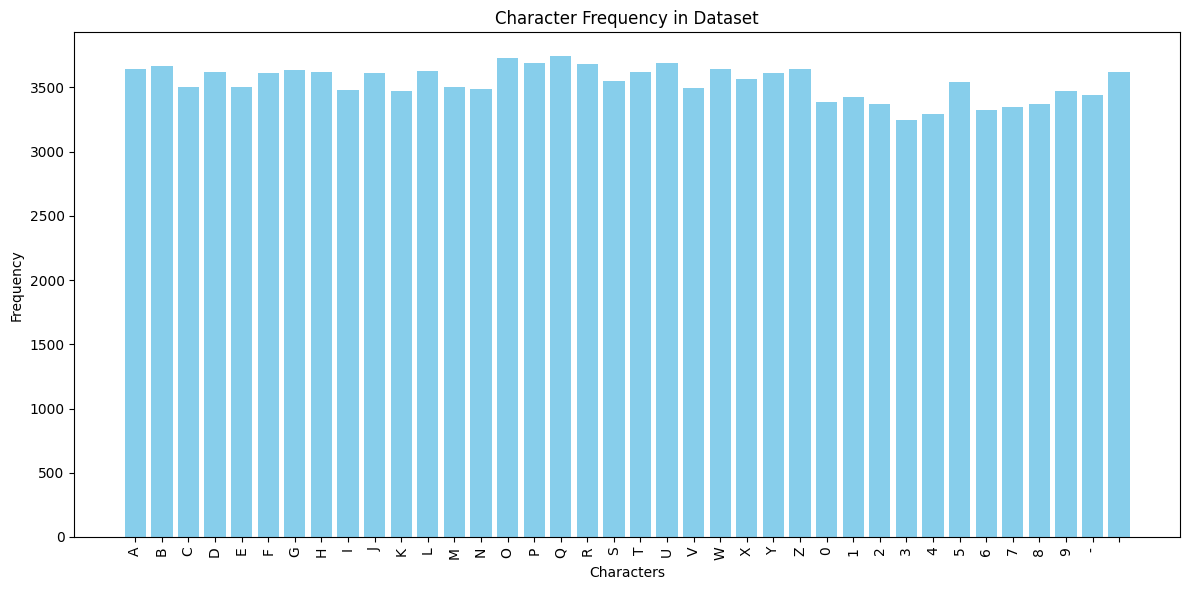

Total characters analyzed: 134474
Character frequencies: {'C': 3500, 'P': 3688, 'U': 3692, '5': 3541, 'D': 3623, 'T': 3617, 'R': 3678, 'B': 3668, '3': 3248, '6': 3327, '4': 3294, 'X': 3567, 'W': 3640, 'H': 3616, 'J': 3611, '0': 3384, 'L': 3625, 'I': 3479, 'O': 3730, '9': 3470, 'V': 3497, 'N': 3488, '1': 3427, 'K': 3472, 'S': 3548, 'E': 3499, '8': 3369, 'Y': 3615, ' ': 3623, 'Q': 3741, 'M': 3506, '-': 3438, '7': 3349, 'F': 3611, '2': 3374, 'G': 3632, 'Z': 3643, 'A': 3644}


[I 2025-04-03 00:59:18,302] A new study created in RDB with name: ocr_multiobjective


Model configuration:
 {'cnn_layers': [{'type': 'conv', 'out_channels': 43, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu', 'dropout': 0.20802027762759395}, {'type': 'pool', 'kernel_size': 2, 'stride': 2}, {'type': 'conv', 'out_channels': 94, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu', 'dropout': 0.28345513602187555}, {'type': 'pool', 'kernel_size': 2, 'stride': 2}, {'type': 'conv', 'out_channels': 136, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu'}, {'type': 'pool', 'kernel_size': (2, 2), 'stride': (2, 1), 'padding': (0, 1)}, {'type': 'conv', 'out_channels': 439, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu'}, {'type': 'pool', 'kernel_size': (2, 2), 'stride': (2, 1), 'padding': (0, 1)}], 'rnn_type': 'lstm', 'rnn_layers': 2, 'hidden_size': 186, 'bidirectional': True, 'dropout': 0.12144942377862007, 'fc_layers': [38]} 



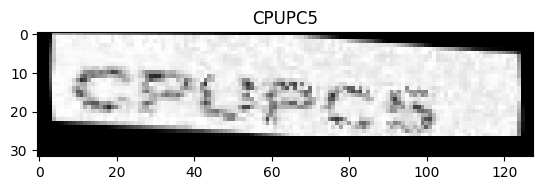

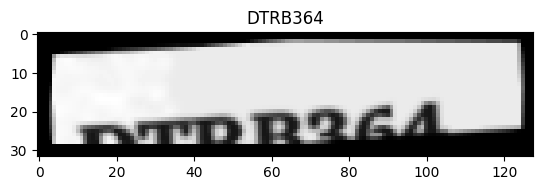

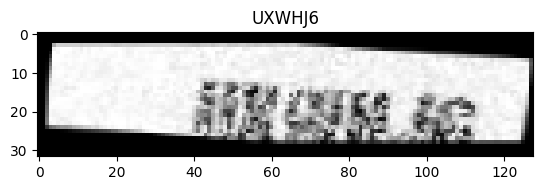

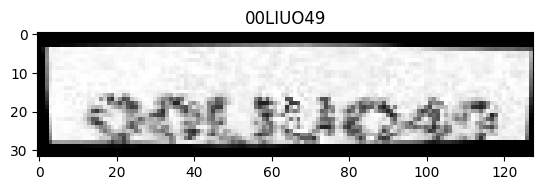

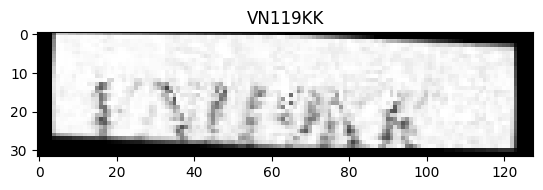

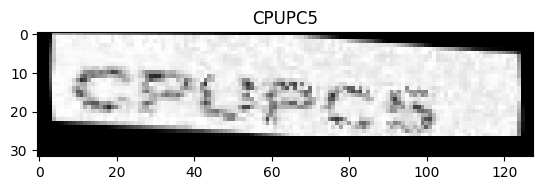

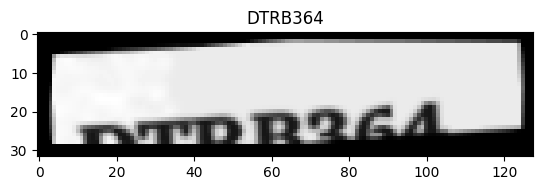

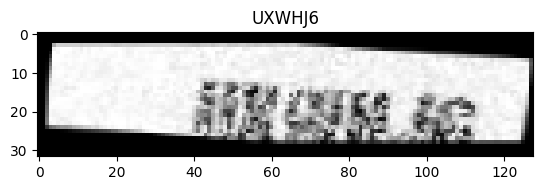

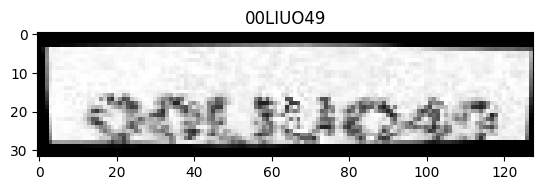

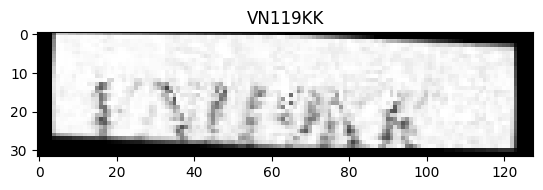

Epoch 1/30, Loss: 5.2745


In [ ]:
if __name__ == "__main__":
    # Synthetic data generation (same as originally)
    if not font_files:
        print("Download some TrueType fonts (.ttf) and place them in the 'fonts' folder!")
        logger.error("Download some TrueType fonts (.ttf) and place them in the 'fonts' folder!")
    else:
        create_synthetic_dataset(NUM_SAMPLES)

    # Path to save the Optuna database
    storage_path = os.path.join(OPTUNA_DIR, 'optuna_study.db')
    storage = f"sqlite:///{storage_path}"
    logger.info("Set database for Optuna optimalization.")

    # Multi-objective study
    study = optuna.create_study(
        directions=["minimize", "minimize", "minimize"],  # Validation loss, grad_norm, blank_probs
        storage=storage,
        study_name="ocr_multiobjective",
        load_if_exists=True
    )
    logger.info("Set & Run Optuna optimalization.")
    study.optimize(objective, n_trials=NUMBER_OF_OPTUNA_TRIALS) # You can adjust the number of trials

    #print("Best trials (Pareto front):")
    logger.info("Best trials (Pareto front):")
    for trial in study.best_trials:
        #print(f"  Trial {trial.number}:")
        logger.info(f"Trial {trial.number}:")
        #print(f"    Values: val_loss={trial.values[0]}, grad_norm={trial.values[1]}, blank_probs={trial.values[2]}")
        logger.info(f"Values: val_loss={trial.values[0]}, grad_norm={trial.values[1]}, blank_probs={trial.values[2]}")
        #print(f"    Params: {trial.params}")
        logger.info(f"Params: {trial.params}")
    
    # Running Optuna Dashboard in the background
    dashboard_thread = threading.Thread(target=run_optuna_dashboard, args=(storage_path,))
    dashboard_thread.start()


In [ ]:
def zip_folder_with_shutil(source_folder, output_path):
    '''Function for zip dir data'''
    shutil.make_archive(output_path, 'zip', source_folder)

In [ ]:
zip_folder_with_shutil('/kaggle/working/backgrounds', '/kaggle/working/backgrounds')
zip_folder_with_shutil('/kaggle/working/synthetic_data', '/kaggle/working/synthetic_data')
zip_folder_with_shutil('/kaggle/working/model_dir', '/kaggle/working/model_dir')
zip_folder_with_shutil('/kaggle/working/runs', '/kaggle/working/runs')
zip_folder_with_shutil('/kaggle/working/optuna', '/kaggle/working/optuna')

In [ ]:
#!tensorboard --logdir=/kaggle/working/runs --port 6006
#!optuna-dashboard sqlite:///kaggle/working/optuna/optuna_study.db